In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skimage.draw import polygon
import PIL
import json
import base64
import os.path
from os.path import splitext
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
#https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html
from keras_segmentation.models.segnet import segnet
from keras_segmentation.models.unet import unet
from keras.models import model_from_json
from keras.models import load_model, save_model

Using TensorFlow backend.


In [2]:
colors = {0 : (0,0,0), 
          1 : (0,0,255), 
          2 : (0,255,0),
          3 : (255,0,0), 
          4 : (0,255,255),         
         }


dim = (256, 256) 

In [3]:
path =  r'/home/inf/Bilder/Road'
dirimages = "images"
dirmasks = "masks"
dirmodels = "models"

dirimagesvalid = "images_valid"
dirmasksvalid = "masks_valid"

dirimagestest = "images_test"
dirmaskstest = "masks_test"

dirpredictions = "predictions"

fullpathimages = os.path.join(path, dirimages)
fullpathmasks = os.path.join(path, dirmasks)
fullpathpredictions = os.path.join(path, dirpredictions)

fullpathimagesvalid = os.path.join(path, dirimagesvalid)
fullpathmasksvalid = os.path.join(path, dirmasksvalid)

fullpathimagestest = os.path.join(path, dirimagestest)
fullpathmaskstest = os.path.join(path, dirmaskstest)

print(os.path.exists(fullpathimagesvalid))
print(os.path.exists(fullpathmasks))
print(os.path.exists(fullpathpredictions))
print(os.path.exists(os.path.join(path, dirmodels)))

True
True
True
True


# Seg Net

In [4]:
model = unet(len(colors), input_height=dim[0], input_width=dim[1])
#model = segnet(20, input_height=dim[0], input_width=dim[1])

In [5]:
help(model.train)

Help on method train in module keras_segmentation.train:

train(train_images, train_annotations, input_height=None, input_width=None, n_classes=None, verify_dataset=True, checkpoints_path=None, epochs=5, batch_size=2, validate=False, val_images=None, val_annotations=None, val_batch_size=2, auto_resume_checkpoint=False, load_weights=None, steps_per_epoch=512, val_steps_per_epoch=512, gen_use_multiprocessing=False, ignore_zero_class=False, optimizer_name='adadelta', do_augment=False, augmentation_name='aug_all') method of keras.engine.training.Model instance



In [6]:
#model.train(
#    train_images =  fullpathimages,
#    train_annotations = fullpathmasks,
#    checkpoints_path = path + "/autocheckpoint", epochs=10
#)


model.train(
    train_images =  fullpathimages,
    train_annotations = fullpathmasks,
    checkpoints_path = path + "/autocheckpoint", 
    epochs=10,
    batch_size = 2,
    validate=True,
    val_images=fullpathimagesvalid,
    val_annotations=fullpathmasksvalid,
    val_batch_size=2,
    steps_per_epoch = 1024,
    val_steps_per_epoch=40
)

  4%|▍         | 55/1456 [00:00<00:02, 546.36it/s]

Verifying training dataset


100%|██████████| 80/80 [00:00<00:00, 531.29it/s]


Dataset verified! 
Verifying validation dataset
Dataset verified! 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
1024/1024 [==============================] - 42s 41ms/step - loss: 0.1905 - accuracy: 0.9458 - val_loss: 0.0928 - val_accuracy: 0.9732
saved  /home/inf/Bilder/Road/autocheckpoint.0
Epoch 2/10
1024/1024 [==============================] - 39s 38ms/step - loss: 0.0734 - accuracy: 0.9747 - val_loss: 0.1011 - val_accuracy: 0.9761
saved  /home/inf/Bilder/Road/autocheckpoint.1
Epoch 3/10
1024/1024 [==============================] - 39s 38ms/step - loss: 0.0571 - accuracy: 0.9800 - val_loss: 0.0586 - val_accuracy: 0.9780
saved  /home/inf/Bilder/Road/autocheckpoint.2
Epoch 4/10
1024/1024 [==============================] - 39s 38ms/step - loss: 0.0476 - accuracy: 0.9829 - val_loss: 0.0604 - val_accuracy: 0.9827
saved  /home/inf/Bilder/Road/autocheckpoint.3
Epoch 5/10
1024/1024 [==============================] - 39s 38ms/step 

In [7]:
modelweightname = "roadunet256-lib.h5"
#modelweightname = "modelsegnet256.h5"

In [8]:
model.save_weights(os.path.join(path, dirmodels,modelweightname))


In [9]:
#model = segnet(len(colors), input_height=dim[0], input_width=dim[1])
#model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [10]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 258, 258, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [9]:
imagetestlist = []

imagetestnames = os.listdir(fullpathimagesvalid)
imagetestnames.sort()

for imagename in imagetestnames:
    if imagename.endswith(".png"):
        imagetestlist.append(cv2.imread(os.path.join(fullpathimagesvalid,imagename),cv2.IMREAD_COLOR ))

In [10]:
j = 1
out = model.predict_segmentation(
    inp=imagetestlist[j],
    #out_fname=fullpathpredictions+"/out.png",
)

In [11]:
print(out.shape)

(128, 128)


In [12]:
def makemask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], 3), 'uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
                assert(mask[i,j] < len(colors))
                #if mask[i,j] < len(colors):
                ret_mask[i,j,0] = colors[mask[i,j]][0]
                ret_mask[i,j,1] = colors[mask[i,j]][1]
                ret_mask[i,j,2] = colors[mask[i,j]][2]
                #print(colors[mask[i,j]])
                #print(mask[i,j])
    return ret_mask

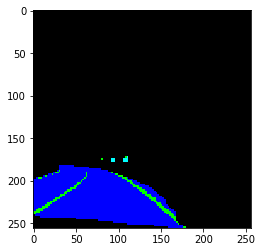

In [14]:
img = makemask(out)

mask = np.zeros((dim[0], dim[1], 3), 'uint8')

mask = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

plt.imshow(mask)

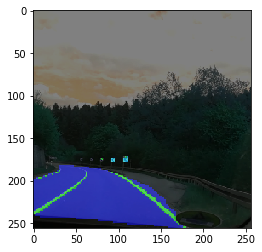

In [15]:
weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
cv2.addWeighted(imagetestlist[j], 0.5, mask, 0.5, 0, weighted)
plt.imshow(weighted)

In [16]:
#cv2.imwrite(os.path.join(path,"comparison","image5-predict.png"),weighted)


for i in range(len(imagetestlist)):
    
    out = model.predict_segmentation(inp=imagetestlist[i])
    img = makemask(out)
    mask = np.zeros((dim[0], dim[1], 3), 'uint8')
    mask = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
    cv2.addWeighted(imagetestlist[i], 0.5, mask, 0.5, 0, weighted)
    #plt.imshow(weighted)
    cv2.imwrite(os.path.join(path,"predictions","image{}-predict.png".format(i)),weighted)

# Unet Model 128

In [17]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten, ZeroPadding2D, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    c10 = Conv2D(len(colors), (1, 1), activation="softmax") (c9)
    
    #c11 = Flatten() (c10)
    #c12 = Dense(dim[0]*dim[1]) (c11)
    #c12 = Reshape((256,256,)) (c11)
    
    model = Model(inputs=[input_img], outputs=[c10])
    return model

In [29]:
def makemask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], 3), 'uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
                assert(mask[i,j] < len(colors))
                #if mask[i,j] < len(colors):
                ret_mask[i,j,0] = colors[mask[i,j]][0]
                ret_mask[i,j,1] = colors[mask[i,j]][1]
                ret_mask[i,j,2] = colors[mask[i,j]][2]
                #print(colors[mask[i,j]])
                #print(mask[i,j])
    return ret_mask

In [45]:
def makecolormask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], len(colors)), 'uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
                assert(mask[i,j] < len(colors))
                ret_mask[i,j,mask[i,j]] = 1
            
#    count = 0
#    for i in range(mask.shape[0]):
#        for j in range(mask.shape[1]):
#            hit = False
#            for k in range(len(colors)):
#                if ret_mask[i, j, k] == 1:
#                    if hit == True:
#                        assert(0 > 1)
#                    else:
#                        hit = True
#                    if k > 1:
#                        count += 1
                    
        
    return ret_mask

In [33]:
imagenames = os.listdir(fullpathimages)
imagenames.sort()

masknames = os.listdir(fullpathmasks)
masknames.sort()

assert(len(imagenames) == len(masknames))

for i in range(len(imagenames)):
    assert(imagenames[i] == masknames[i])
    
imagenamesvalid = os.listdir(fullpathimagesvalid)
imagenamesvalid.sort()

masknamesvalid = os.listdir(fullpathmasksvalid)
masknamesvalid.sort()

assert(len(imagenamesvalid) == len(masknamesvalid))

for i in range(len(imagenamesvalid)):
    assert(imagenamesvalid[i] == masknamesvalid[i])

In [31]:
def generatebatchdata(batchsize, fullpathimages, fullpathmasks, imagenames, masknames):
  
    assert(len(imagenames) == len(masknames))

    while True:
        batchstart = 0
        batchend = batchsize    
        
        while batchstart < len(imagenames):
            
            imagelist = []
            masklist = []
            
            limit = min(batchend, len(imagenames))

            for i in range(batchstart, limit):
                if imagenames[i].endswith(".png"):
                    imagelist.append(cv2.imread(os.path.join(fullpathimages,imagenames[i]),cv2.IMREAD_COLOR ))
                if masknames[i].endswith(".png"):
                    masklist.append(makecolormask(cv2.imread(os.path.join(fullpathmasks,masknames[i]),cv2.IMREAD_UNCHANGED )))


            train_data = np.array(imagelist, dtype=np.float32)
            train_mask= np.array(masklist, dtype=np.float32)

            #train_data -= train_data.mean()
            #train_data /= train_data.std()
            train_data /= 255.0
    
            yield (train_data,train_mask)    

            batchstart += batchsize   
            batchend += batchsize



In [34]:
generator_train = generatebatchdata(2, fullpathimages, fullpathmasks, imagenames, masknames)
generator_valid = generatebatchdata(2, fullpathimagesvalid, fullpathmasksvalid,  imagenamesvalid, masknamesvalid)

In [11]:
input_img = Input((dim[0], dim[1], 3), name='img')
model = get_unet(input_img, n_filters=len(colors), dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
#model.summary()

In [35]:
modeljsonname="model-chkpt.json"
modelweightname="model-chkpt.h5"

#model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [36]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(path, dirmodels,modelweightname), verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
#results = model.fit(train_data, train_mask, batch_size=32, epochs=40, validation_data=(valid_data, valid_mask))
#model.fit_generator(generator_train,steps_per_epoch=3400, nb_epoch=10, callbacks=callbacks, validation_data=generator_valid, validation_steps=540)
model.fit_generator(generator_train,steps_per_epoch=512, epochs=20, callbacks=callbacks, validation_data=generator_valid, validation_steps=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
512/512 [==============================] - 230s 450ms/step - loss: 0.5678 - accuracy: 0.8600 - val_loss: 0.2044 - val_accuracy: 0.9516

Epoch 00001: val_loss improved from inf to 0.20437, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 2/20
512/512 [==============================] - 226s 441ms/step - loss: 0.1546 - accuracy: 0.9603 - val_loss: 0.1551 - val_accuracy: 0.9347

Epoch 00002: val_loss improved from 0.20437 to 0.15513, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 3/20
512/512 [==============================] - 232s 452ms/step - loss: 0.1104 - accuracy: 0.9673 - val_loss: 0.0888 - val_accuracy: 0.9499

Epoch 00003: val_loss improved from 0.15513 to 0.08881, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 4/20
512/512 [==============================] - 231s 451ms/step - loss: 0.0941 - accuracy: 0.9709 - val_loss: 0.06

/home/inf/.virtualenvs/cv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118109). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  2/512 [..............................] - ETA: 6:26 - loss: 0.0522 - accuracy: 0.9772

/home/inf/.virtualenvs/cv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116060). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  3/512 [..............................] - ETA: 7:36 - loss: 0.0562 - accuracy: 0.9754

/home/inf/.virtualenvs/cv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114012). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


512/512 [==============================] - 233s 455ms/step - loss: 0.0535 - accuracy: 0.9798 - val_loss: 0.0313 - val_accuracy: 0.9779

Epoch 00011: val_loss improved from 0.04174 to 0.03132, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 12/20
512/512 [==============================] - 229s 447ms/step - loss: 0.0507 - accuracy: 0.9806 - val_loss: 0.0300 - val_accuracy: 0.9780

Epoch 00012: val_loss improved from 0.03132 to 0.02995, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 13/20
512/512 [==============================] - 230s 449ms/step - loss: 0.0495 - accuracy: 0.9809 - val_loss: 0.0288 - val_accuracy: 0.9780

Epoch 00013: val_loss improved from 0.02995 to 0.02882, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 14/20
512/512 [==============================] - 229s 448ms/step - loss: 0.0485 - accuracy: 0.9811 - val_loss: 0.0286 - val_accuracy: 0.9778

Epoch 00014: val_loss improved from 0.02882 to 0.02860, saving model to 

In [15]:
modeljsonname="roadunet256.json"
modelweightname="roadunet256.h5"

In [16]:
model_json = model.to_json()
with open(os.path.join(path, dirmodels,modeljsonname), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(path, dirmodels,modelweightname))


In [74]:
imagetestlist = []

imagetestnames = os.listdir(fullpathimagesvalid)
imagetestnames.sort()

for imagename in imagetestnames:
    if imagename.endswith(".png"):
        imagetestlist.append(cv2.imread(os.path.join(fullpathimagesvalid,imagename),cv2.IMREAD_COLOR ))
        
test_data = np.array(imagetestlist, dtype=np.float32)
#test_data -= test_data.mean()
#test_data /= test_data.std()
test_data /= 255.0

In [55]:
masktestlist = []

masktestnames = os.listdir(fullpathmaskstest)
masktestnames.sort()

for maskname in masktestnames:
    if maskname.endswith(".png"):
        masktestlist.append(makecolormask(cv2.imread(os.path.join(fullpathmaskstest,maskname),cv2.IMREAD_UNCHANGED )))

In [20]:
json_file = open(os.path.join(path, dirmodels,modeljsonname), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [75]:
predictions_test = model.predict(test_data, batch_size=1, verbose=1)

80/80 [==============================] - 1s 10ms/step


In [76]:
len(predictions_test)

80

In [77]:
print(predictions_test[0].shape)

(256, 256, 5)


In [59]:
def predictedmask(masklist):
    y_list = []
    for mask in masklist:
        assert mask.shape == (dim[0], dim[1], len(colors))
        imgret = np.zeros((dim[0], dim[1]), np.uint8)
        for i in range(dim[0]):
            for j in range(dim[1]):
                result = np.where(mask[i,j,:] == np.amax(mask[i,j,:]))
                assert result[0][0] < len(colors)
                imgret[i,j] = result[0][0]
        y_list.append(imgret)
        #for k in range(len(colors)):
        #    sum1 = 0;
        #    for i in range(dim[0]):
        #        for j in range(dim[1]):
        #                sum1  += mask[i,j,k]
        #    print("{}: {}".format(k, sum1))
                    
    return y_list

In [53]:
#print(predictions_test[0][50,50,:])
#maxElement = np.amax(predictions_test[0][0,0,:])
#print(maxElement)
#result = np.where(predictions_test[0][50,50,:] == np.amax(predictions_test[0][50,50,:]))
#print(result[0][0])

In [54]:
#predictedmask(masktestlist)
#np.set_printoptions(threshold=np.inf)
#masktestlist[1][100,90:120,:]
#predictions_test[3]
#predictedmask(predictions_test)

In [55]:
#predictions_test[1][100,90:120,:]

In [60]:
mymasks = predictedmask(predictions_test)

#mymasks = predictedmask(masktestlist)

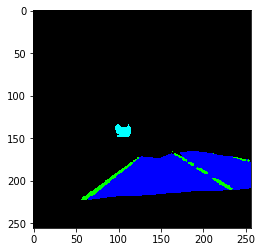

In [68]:
ind = 1

img = np.zeros((dim[0], dim[1], 3), 'uint8')

img = makemask(mymasks[ind])
#img = predictedmask(masktestlist)


plt.imshow(img)

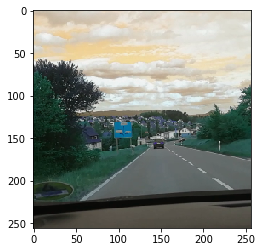

In [69]:
plt.imshow(imagetestlist[ind])

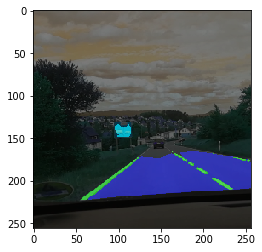

In [70]:
weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
cv2.addWeighted(imagetestlist[ind], 0.5, img, 0.5, 0, weighted)
plt.imshow(weighted)

In [78]:

#test_data = np.array(imagetestlist, dtype=np.float32)
#test_data -= test_data.mean()
#test_data /= test_data.std()

#predictions_test = model.predict(test_data, batch_size=1, verbose=1)

manymasks = predictedmask(predictions_test)

assert(len(manymasks) == len(imagetestlist))

for i in range(len(manymasks)):
    #img = makemask(manymasks[i])
    #mask = np.zeros((dim[0], dim[1], 3), 'uint8')
    weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
    cv2.addWeighted(imagetestlist[i], 0.5, makemask(manymasks[i]), 0.5, 0, weighted)
    #plt.imshow(weighted)
    cv2.imwrite(os.path.join(path,"predictions","image{}-predict.png".format(i)),weighted)

KeyboardInterrupt: 

# My UNET

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten, ZeroPadding2D, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
def my_unet(classes):
    
    dropout = 0.4
    input_img = Input(shape=(dim[0], dim[1], 3))
    
    #contracting
    x = (ZeroPadding2D((1, 1)))(input_img)
    x = (Conv2D(64, (3, 3), padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((2, 2)))(x)
    c0 = Dropout(dropout)(x)
    
    x = (ZeroPadding2D((1, 1)))(c0)
    x = (Conv2D(128, (3, 3),padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((2, 2)))(x)
    c1 = Dropout(dropout)(x)

    x = (ZeroPadding2D((1, 1)))(c1)
    x = (Conv2D(256, (3, 3), padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((2, 2)))(x)
    c2 = Dropout(dropout)(x)
    
    x = (ZeroPadding2D((1, 1)))(c2)
    x = (Conv2D(256, (3, 3), padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((2, 2)))(x)
    c3 = Dropout(dropout)(x)
    
    x = (ZeroPadding2D((1, 1)))(c3)
    x = (Conv2D(512, (3, 3), padding='valid'))(x)
    c4 = (BatchNormalization())(x)

    x = (UpSampling2D((2, 2)))(c4)
    x = (concatenate([x, c2], axis=-1))
    x = Dropout(dropout)(x)
    x = (ZeroPadding2D((1, 1)))(x)
    x = (Conv2D(256, (3, 3), padding='valid', activation='relu'))(x)
    e4 = (BatchNormalization())(x)
    
    x = (UpSampling2D((2, 2)))(e4)
    x = (concatenate([x, c1], axis=-1))
    x = Dropout(dropout)(x)
    x = (ZeroPadding2D((1, 1)))(x)
    x = (Conv2D(256, (3, 3), padding='valid', activation='relu'))(x)
    e3 = (BatchNormalization())(x)
    
    x = (UpSampling2D((2, 2)))(e3)
    x = (concatenate([x, c0], axis=-1))
    x = Dropout(dropout)(x)
    x = (ZeroPadding2D((1, 1)))(x)
    x = (Conv2D(64, (3, 3), padding='valid', activation='relu'))(x)
    x = (BatchNormalization())(x)

    x = (UpSampling2D((2, 2)))(x)
    x = Conv2D(classes, (3, 3), padding='same')(x)
    
    x = (Activation('softmax'))(x)
    
    model = Model(input_img, x)
        
    return model





  

In [13]:
model = my_unet(len(colors))
model.compile(loss="categorical_crossentropy",optimizer="adadelta", metrics=['accuracy'])

In [14]:
#model.summary()

In [15]:
def makecolormask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], len(colors)), 'uint8')
    
    for col in range(len(colors)):
        ret_mask[:, :, col] = (mask == col).astype(int)
                       
    return ret_mask

In [16]:
modeljsonname="model-chkpt.json"
modelweightname="model-chkpt.h5"

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(path, dirmodels,modelweightname), verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
def generatebatchdata(batchsize, fullpathimages, fullpathmasks):
  
    imagenames = os.listdir(fullpathimages)
    imagenames.sort()

    masknames = os.listdir(fullpathmasks)
    masknames.sort()

    assert(len(imagenames) == len(masknames))
    
    for i in range(len(imagenames)):
        assert(imagenames[i] == masknames[i])

    while True:
        batchstart = 0
        batchend = batchsize    
        
        while batchstart < len(imagenames):
            
            imagelist = []
            masklist = []
            
            limit = min(batchend, len(imagenames))

            for i in range(batchstart, limit):
                if imagenames[i].endswith(".png"):
                    imagelist.append(cv2.imread(os.path.join(fullpathimages,imagenames[i]),cv2.IMREAD_COLOR ))
                if masknames[i].endswith(".png"):
                    masklist.append(makecolormask(cv2.imread(os.path.join(fullpathmasks,masknames[i]),cv2.IMREAD_UNCHANGED )))


            train_data = np.array(imagelist, dtype=np.float32)
            train_mask= np.array(masklist, dtype=np.float32)

            train_data /= 255.0
    
            yield (train_data,train_mask)    

            batchstart += batchsize   
            batchend += batchsize

In [18]:
generator_train = generatebatchdata(2, fullpathimages, fullpathmasks)
generator_valid = generatebatchdata(2, fullpathimagesvalid, fullpathmasksvalid)

In [19]:
model.fit_generator(generator_train,steps_per_epoch=700, epochs=10, callbacks=callbacks, validation_data=generator_valid, validation_steps=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
700/700 [==============================] - 37s 52ms/step - loss: 0.1461 - accuracy: 0.9607 - val_loss: 0.0537 - val_accuracy: 0.9421

Epoch 00001: val_loss improved from inf to 0.05368, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 2/10
700/700 [==============================] - 33s 48ms/step - loss: 0.0744 - accuracy: 0.9760 - val_loss: 0.0941 - val_accuracy: 0.9473

Epoch 00002: val_loss did not improve from 0.05368
Epoch 3/10
700/700 [==============================] - 34s 48ms/step - loss: 0.0620 - accuracy: 0.9796 - val_loss: 0.0503 - val_accuracy: 0.9536

Epoch 00003: val_loss improved from 0.05368 to 0.05026, saving model to /home/inf/Bilder/Road/models/model-chkpt.h5
Epoch 4/10
700/700 [==============================] - 34s 48ms/step - loss: 0.0536 - accuracy: 0.9816 - val_loss: 0.1013 - val_accuracy: 0.9618

Epoch 00004: val_loss did not improve from 0.0

In [20]:
modeljsonname="roadunet256-my-dropout-huge.json"
modelweightname="roadunet256-my-dropout-huge.h5"

In [21]:
model_json = model.to_json()
with open(os.path.join(path, dirmodels,modeljsonname), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(path, dirmodels,modelweightname))

In [22]:
model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [23]:
imagetestlist = []

imagetestnames = os.listdir(fullpathimagestest)
imagetestnames.sort()

for imagename in imagetestnames:
    if imagename.endswith(".png"):
        imagetestlist.append(cv2.imread(os.path.join(fullpathimagestest,imagename),cv2.IMREAD_COLOR ))
        
test_data = np.array(imagetestlist, dtype=np.float32)
test_data /= 255.0

In [24]:
predictions_test = model.predict(test_data, batch_size=1, verbose=1)

5/5 [==============================] - 1s 131ms/step


In [18]:
#def predictedmask(masklist):
#    y_list = []
#    for mask in masklist:
#        assert mask.shape == (dim[0], dim[1], len(colors))
#        imgret = np.zeros((dim[0], dim[1]), np.uint8)
#        for i in range(dim[0]):
#            for j in range(dim[1]):
#                result = np.where(mask[i,j,:] == np.amax(mask[i,j,:]))
#                assert result[0][0] < len(colors)
#                imgret[i,j] = result[0][0]
#        y_list.append(imgret)
#                    
#    return y_list

In [25]:
def predictedmask(masklist):
    y_list = []
    for mask in masklist:
        assert mask.shape == (dim[0], dim[1], len(colors))
        imgret = np.zeros((dim[0], dim[1]), np.uint8)

        ##imgret = np.where(mask[:,:,:] == np.amax(mask[:,:,:]))
        #assert result < len(colors)
        #imgret = result[0][0]
        
        imgret = mask.argmax(axis=2)
        
        #print(imgret)
                
        y_list.append(imgret)
                    
    return y_list

In [26]:
def makemask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], 3), 'uint8')

    for col in range(len(colors)):
        layer = mask[:, :] == col
        ret_mask[:, :, 0] += ((layer)*(colors[col][0])).astype('uint8')
        ret_mask[:, :, 1] += ((layer)*(colors[col][1])).astype('uint8')
        ret_mask[:, :, 2] += ((layer)*(colors[col][2])).astype('uint8')
    
    return ret_mask

In [27]:
mymasks = predictedmask(predictions_test)

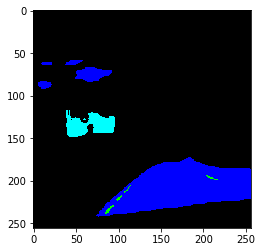

In [40]:
ind = 3

img = np.zeros((dim[0], dim[1], 3), 'uint8')

img = makemask(mymasks[ind])

plt.imshow(img)

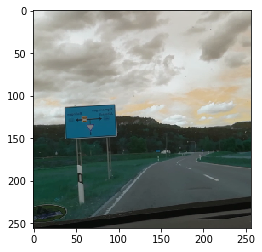

In [41]:
plt.imshow(imagetestlist[ind])

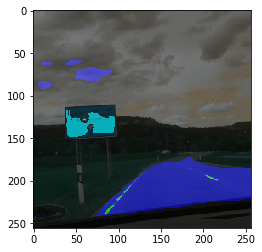

In [42]:
weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
cv2.addWeighted(imagetestlist[ind], 0.5, img, 0.5, 0, weighted)
plt.imshow(weighted)